<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [8]:
!pip install datasets

Импорт необходимых библиотек

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import nltk
import string

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [12]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [13]:
sentences = []
word_threshold = 32

for one_text in tqdm(dataset['train']['text']):
    tokenized_sentences = [sentence.lower() for sentence in sent_tokenize(one_text, language='russian')]
    sentences.extend([sentence for sentence in tokenized_sentences if len(sentence.split()) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [14]:
print("Всего предложений:", len(sentences))

Всего предложений: 221797


Посчитаем для каждого слова его встречаемость.

In [15]:
words = Counter()

for sent in tqdm(sentences):
    for word in word_tokenize(sent):
        words[word] += 1

  0%|          | 0/221797 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [16]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

for word, _ in words.most_common(vocab_size):
    vocab.add(word)

In [17]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [18]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [19]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [20]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        processed_sentence = self.data[idx].lower().translate(
            str.maketrans('','', string.punctuation)
        )
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(processed_sentence)]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [21]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [22]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [23]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [24]:
def train_model(model,
                train_loader,
                eval_loader,
                loss_criterion,
                opt,
                sched,
                num_epochs = 5):
    """
    Training loop of one model
    """
    min_perplexity = 10000
    perplexity_list = []
    loss_list = []
    model = model.to(device)

    for epoch in tqdm(range(num_epochs)):
        epoch_losses = []
        model.train()
        for batch in train_loader:
            opt.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1).to(device)
            loss = loss_criterion(logits, batch['target_ids'].flatten().to(device))
            loss.backward()
            opt.step()
            epoch_losses.append(loss.item())
        sched.step()
        epoch_loss = np.array(epoch_losses).mean()
        loss_list.append(epoch_loss)
        perplexity = evaluate(model, loss_criterion, eval_loader)
        perplexity_list.append(perplexity)
        if perplexity < min_perplexity:
            min_perplexity = perplexity
            best_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'perplexity': perplexity,
                'loss': epoch_loss
            }
        history = {
            'losses': loss_list,
            'perplexities': perplexity_list
        }
        print(f'Trained epoch {epoch} with loss {epoch_loss:.2f} and perplexity {perplexity:.2f}')
    clear_output()
    return best_checkpoint, history

### Первый эксперимент (2 балла)

В первой группе экспериментов мы исследуем зависимость результатов обучения модели от того, какой рекуррентный блок используется внутри нее. При определении класса модели добавляем параметр `rnn_type`, который равен `rnn` для стандартного RNN, либо `lstm` или `gru`.

In [25]:
class LanguageModel1(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, n_layers: int = 1, rnn_type: str = 'rnn'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        if rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, n_layers, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)
        else:
            raise ValueError('Wrong type of RNN block!')
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch) # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output))) # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output)) # [batch_size, seq_len, vocab_size]
        return projection

In [29]:
n_epochs = 15
history = torch.load('/kaggle/input/dls-s2-h03/pytorch/v1/1/history.pt')
best_checkpoints = torch.load('/kaggle/input/dls-s2-h03/pytorch/v1/1/best_checkpoints.pt')
types_rnn = ['rnn', 'gru', 'lstm']


for i, type_rnn in zip(range(3), types_rnn):
    model = LanguageModel1(
        hidden_dim=256,
        vocab_size=len(vocab),
        rnn_type=type_rnn)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = StepLR(optimizer, step_size=1, gamma=0.8)
    print('Training model', i)
    best_checkpoints[i], history[i] = train_model(model, train_dataloader, eval_dataloader,
                                                  criterion, optimizer, scheduler, n_epochs)
torch.save(history, 'history.pt')
torch.save(best_checkpoints, 'best_checkpoints.pt')

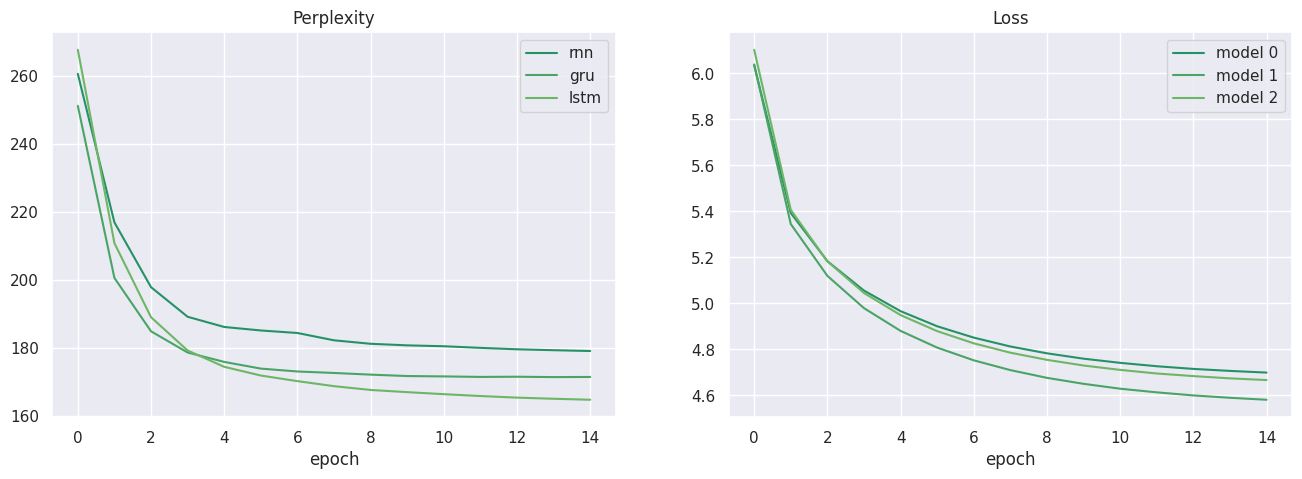

In [20]:
history = torch.load('/kaggle/input/dls-s2-h03/pytorch/v1/1/history.pt', map_location=torch.device('cpu'))
best_checkpoints = torch.load('/kaggle/input/dls-s2-h03/pytorch/v1/1/best_checkpoints.pt', map_location=torch.device('cpu'))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
for i, label in enumerate(['rnn', 'gru', 'lstm']):
    perplexities = history[i]['perplexities']
    losses = history[i]['losses']
    ax1.plot(perplexities, label=f'{label}')
    ax1.set_title('Perplexity')
    ax1.set_xlabel('epoch')
    ax1.legend()
    ax2.plot(losses, label=f'model {i}')
    ax2.set_title('Loss')
    ax2.set_xlabel('epoch')
    ax2.legend()

Итак, по графикам видно, что наилучшей перплексией обладает модель с блоком `lstm`. Теперь попробуем увеличить количество слоев RNN при помощи параметра `n_layers`.

In [28]:
n_epochs = 15
n_layers = [2, 3]


for i, n_l in zip(range(3, 5), n_layers):
    model = LanguageModel1(
        hidden_dim=256,
        vocab_size=len(vocab),
        rnn_type='lstm',
        n_layers = n_l)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = StepLR(optimizer, step_size=1, gamma=0.8)
    print('Training model', i)
    best_checkpoints[i], history[i] = train_model(model, train_dataloader, eval_dataloader,
                                                  criterion, optimizer, scheduler, n_epochs)
torch.save(history, 'history.pt')
torch.save(best_checkpoints, 'best_checkpoints.pt')

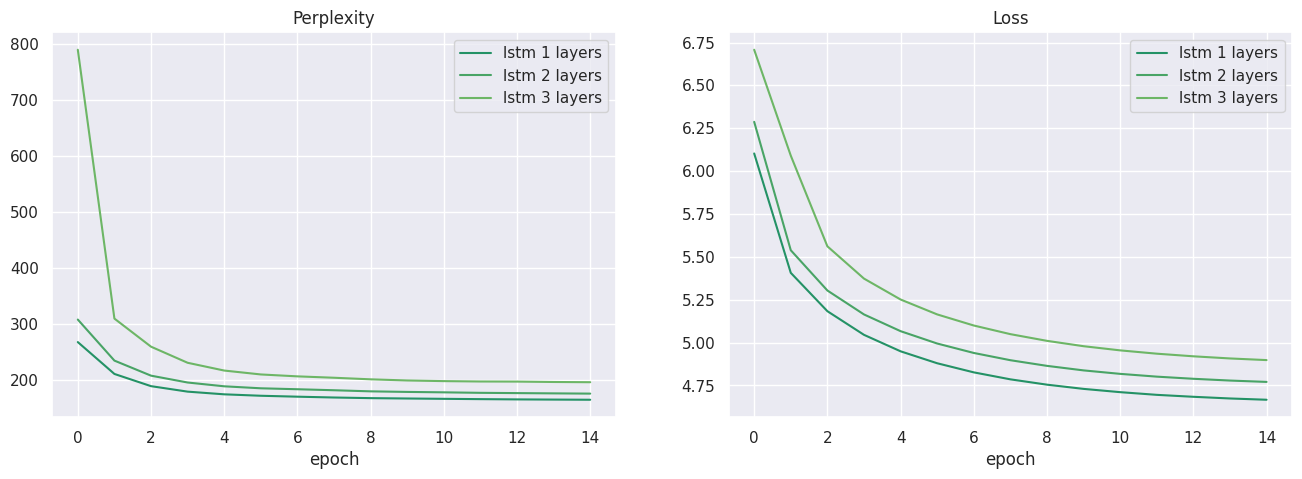

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
for i, n_lay in enumerate([1, 2, 3]):
    perplexities = history[i+2]['perplexities']
    losses = history[i+2]['losses']
    ax1.plot(perplexities, label=f'lstm {n_lay} layers')
    ax1.set_title('Perplexity')
    ax1.set_xlabel('epoch')
    ax1.legend()
    ax2.plot(losses, label=f'lstm {n_lay} layers')
    ax2.set_title('Loss')
    ax2.set_xlabel('epoch')
    ax2.legend()

Перплексия растет с увеличением количества слоев LSTM.

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [26]:
class LanguageModel2(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, n_layers: int = 1, n_linears: int = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.linear0 = nn.Linear(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, 2*hidden_dim)
        self.linear2 = nn.Linear(2*hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.n_linears = n_linears

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch) # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim]
        if self.n_linears == 1:
            output = self.dropout(self.linear0(self.non_lin(output))) # [batch_size, seq_len, hidden_dim]
        elif self.n_linears == 2:
            output = self.dropout(self.linear1(self.non_lin(output)))
            output = self.dropout(self.linear2(self.non_lin(output)))
        else:
            raise ValueError('Param n_linears should be 1 or 2')
        projection = self.projection(self.non_lin(output)) # [batch_size, seq_len, vocab_size]
        return projection

Сначала проведем эксперимент по увеличению размера скрытого состояния. Проверим значения `512` и `1024`.

In [70]:
n_epochs = 15

for i, h_dim in zip([5, 6], [512, 1024]):
    model = LanguageModel2(
        hidden_dim=h_dim,
        vocab_size=len(vocab)
    )
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = StepLR(optimizer, step_size=1, gamma=0.8)
    print('Training model', i)
    best_checkpoints[i], history[i] = train_model(model, train_dataloader, eval_dataloader,
                                                  criterion, optimizer, scheduler, n_epochs)

torch.save(history, 'history.pt')
torch.save(best_checkpoints, 'best_checkpoints.pt')

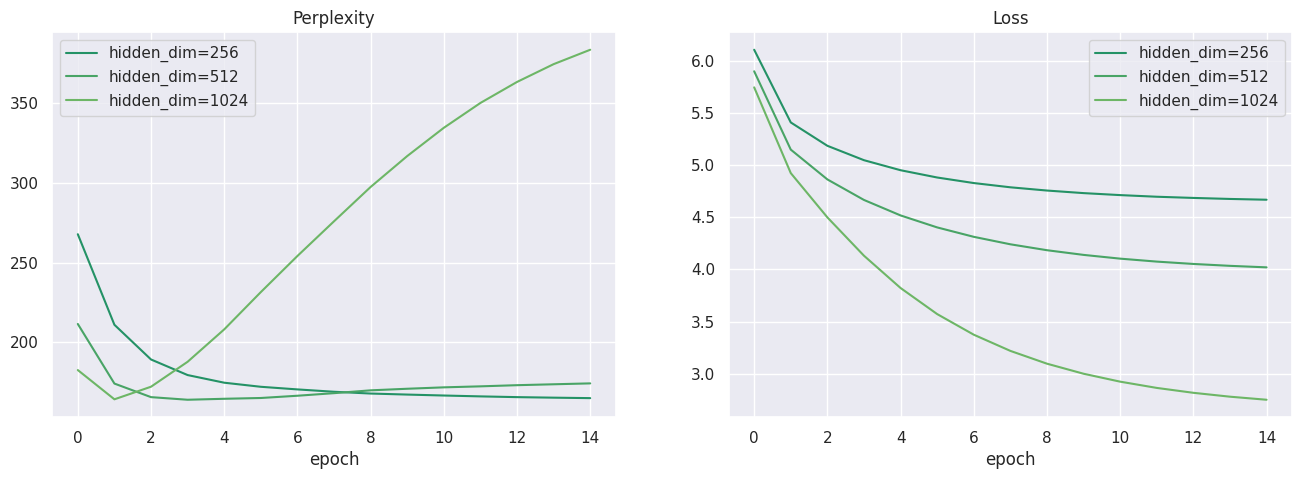

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
for i, h_dim in zip([2, 5, 6], [256, 512, 1024]):
    perplexities = history[i]['perplexities']
    losses = history[i]['losses']
    ax1.plot(perplexities, label=f'hidden_dim={h_dim}')
    ax1.set_title('Perplexity')
    ax1.set_xlabel('epoch')
    ax1.legend()
    ax2.plot(losses, label=f'hidden_dim={h_dim}')
    ax2.set_title('Loss')
    ax2.set_xlabel('epoch')
    ax2.legend()

Здесь видно, что при больших размерах скрытого состояния наблюдается переобучение. В частности, при hidden_dim=1024 наблюдается резкий рост перплексии уже на второй эпохе. Теперь попробуем добавить еще один линейный слой.

In [33]:
model = LanguageModel2(
    hidden_dim=256,
    vocab_size=len(vocab),
    n_linears=2
)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)
print('Training model', 7)
best_checkpoints[7], history[7] = train_model(model, train_dataloader, eval_dataloader,
                                                  criterion, optimizer, scheduler, n_epochs)
torch.save(history, 'history.pt')
torch.save(best_checkpoints, 'best_checkpoints.pt')

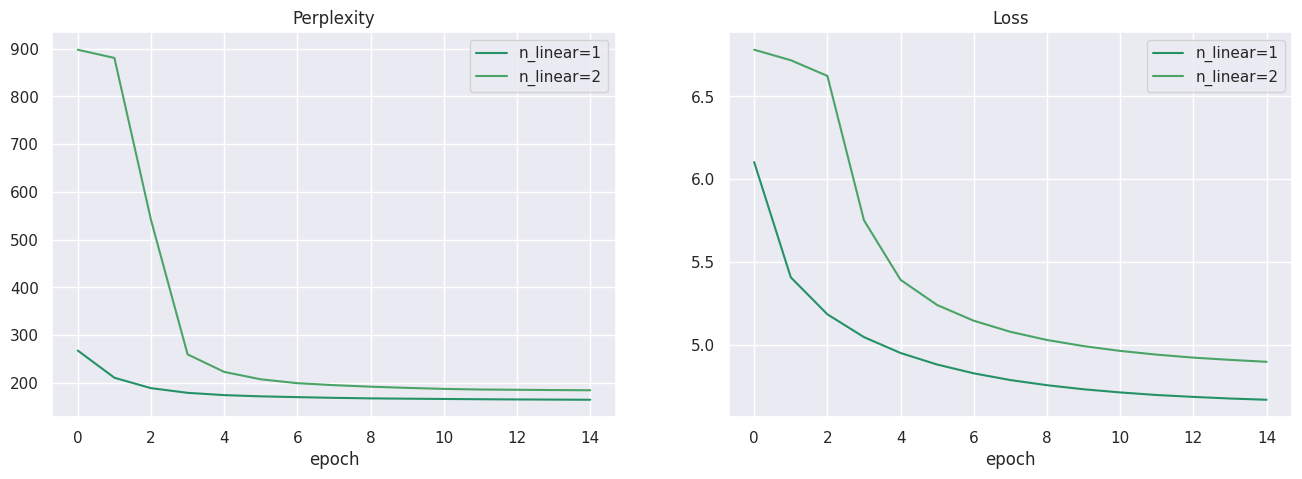

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
for i, n_lin in zip([2, 7], [1, 2]):
    perplexities = history[i]['perplexities']
    losses = history[i]['losses']
    ax1.plot(perplexities, label=f'n_linear={n_lin}')
    ax1.set_title('Perplexity')
    ax1.set_xlabel('epoch')
    ax1.legend()
    ax2.plot(losses, label=f'n_linear={n_lin}')
    ax2.set_title('Loss')
    ax2.set_xlabel('epoch')
    ax2.legend()

При добавлении еще одного линейного слоя перплексия снова снизилась

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Подведем итоги проделанной работы. Было проведено два эксперимента, в первом из которых были протестированы различные RNN блоки, а также различное их количество в одной модели при использовании LSTM. Во втором эксперименте вначале был увеличен размер вектора скрытого состояния модели, а затем был добавлен еще один линейный слой. Во всех экспериментах модель успешно обучилась, кроме эксперимента с увеличением `hidden_dim` до 1024, где наблюдалось переобучение. Соберем воедино все графики перплексии и лосса для восьми обученных в процессе работы моделей. Построим датафрейм с результатами экспериментов.

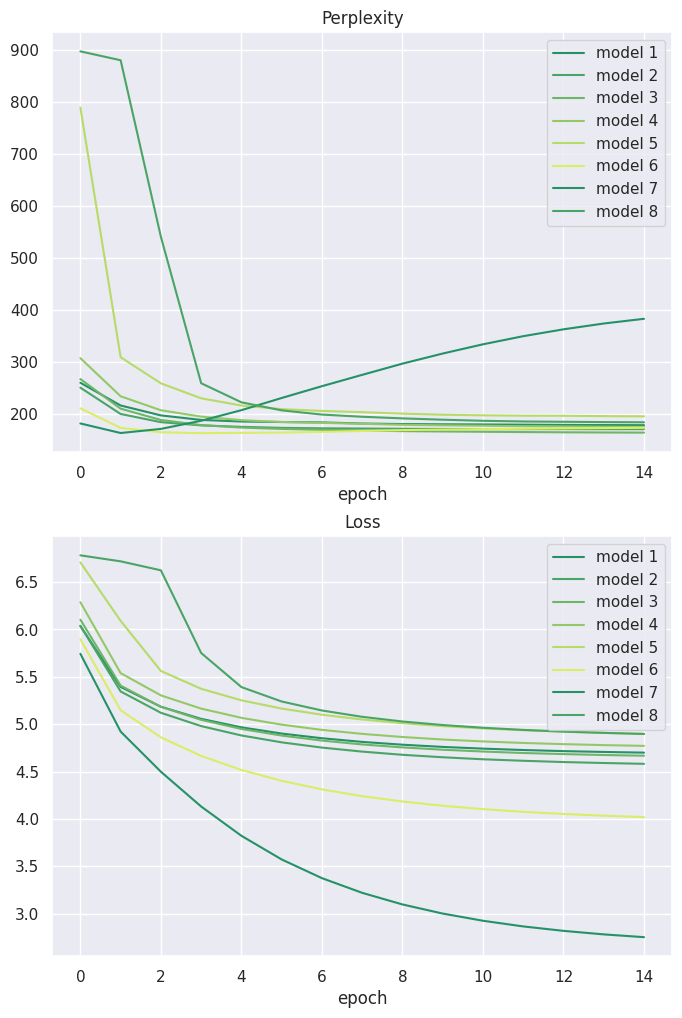

In [29]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,12))
N_MODELS = 8
for i in range(N_MODELS):
    perplexities = history[i]['perplexities']
    losses = history[i]['losses']
    ax1.plot(perplexities, label=f'model {i+1}')
    ax1.set_title('Perplexity')
    ax1.set_xlabel('epoch')
    ax1.legend()
    ax2.plot(losses, label=f'model {i+1}')
    ax2.set_title('Loss')
    ax2.set_xlabel('epoch')
    ax2.legend()
plt.suptitle()

In [36]:
summary_dict = {}
summary_dict['model'] = [f'model {i+1}' for i in range(N_MODELS)]
summary_dict['rnn_block'] = ['rnn', 'gru'] + ['lstm']*(N_MODELS-2)
summary_dict['n_layers'] = [1, 1, 1, 2, 3, 1, 1, 1]
summary_dict['hidden_dim'] = [256]*(N_MODELS-3) + [512, 1024, 256]
summary_dict['n_linear'] = [1]*(N_MODELS-1) + [2]
summary_dict['min_perplexity'] = [best_checkpoints[i]['perplexity'] for i in range(N_MODELS)]
summary_dict['epoch'] = [best_checkpoints[i]['epoch']+1 for i in range(N_MODELS)]
summary_df = pd.DataFrame(summary_dict)
print(summary_df)

     model rnn_block  n_layers  hidden_dim  n_linear  min_perplexity  epoch
0  model 1       rnn         1         256         1      179.214813     15
1  model 2       gru         1         256         1      171.542277     14
2  model 3      lstm         1         256         1      164.879445     15
3  model 4      lstm         2         256         1      175.828003     15
4  model 5      lstm         3         256         1      196.188793     15
5  model 6      lstm         1         512         1      163.861296      4
6  model 7      lstm         1        1024         1      164.138571      2
7  model 8      lstm         1         256         2      184.762157     15


In [38]:
print('Model with best perplexity: ')
print('----------')
print(summary_df.iloc[summary_df['min_perplexity'].idxmin()])

Model with best perplexity: 
----------
model                model 6
rnn_block               lstm
n_layers                   1
hidden_dim               512
n_linear                   1
min_perplexity    163.861296
epoch                      4
Name: 5, dtype: object


Итак, минимальная перплексия получилась для 6-й модели и равна `163.86`.

### Text generation

Теперь попробуем погенерировать текст моделью с наилучшей перплексией.

In [73]:
def generate_text_with_model(model, input_str: str, max_len: int):
    input_ids = [word2ind['<bos>']]
    input_str = input_str.lower().translate(str.maketrans('', '', string.punctuation))
    input_ids += [word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(input_str)]
    model.eval()
    model.to('cpu')
    input_ids = torch.LongTensor(input_ids).to('cpu')
    input_str = [input_str]
    
    for i in range(max_len):
        next_word_dist = model(input_ids)[-1]
        next_word = next_word_dist.argmax()
        input_ids = torch.cat((input_ids, next_word.unsqueeze(0)))
        output_token = ind2word.get(next_word.item())
        input_str.append(output_token)
        if output_token == '<eos>':
            break
    return ' '.join(input_str)

In [75]:
best_model = LanguageModel2(
    hidden_dim=512,
    vocab_size=len(vocab)
)
best_model.load_state_dict(best_checkpoints[5]['model_state_dict'])
generate_text_with_model(best_model, 'The movie was good because', max_len=100)

'the movie was good because it was so bad that it was a good movie <eos>'

In [76]:
generate_sequence(best_model, 'The movie was bad because', max_seq_len=100)

'<bos> the movie was bad because it was so bad that it was a good idea <eos>'

In [77]:
generate_sequence(best_model, 'My first impression was', max_seq_len=100)

'<bos> my first impression was that the film was made in the early 90s <eos>'

In [85]:
generate_sequence(best_model, 'Some scenes', max_seq_len=100)

'<bos> some scenes are so bad that they are not funny <eos>'

In [86]:
generate_sequence(best_model, 'I have just watched', max_seq_len=100)

'<bos> i have just watched this movie on dvd <eos>'

In [90]:
generate_sequence(best_model, 'The plot of the movie', max_seq_len=100)

'<bos> the plot of the movie is a bit slow and the acting is bad <eos>'